In [1]:
!gcloud config set project etsy-bigquery-adhoc-prod


If you have a compatible Python interpreter installed, you can use it by setting
the CLOUDSDK_PYTHON environment variable to point to it.

Updated property [core/project].


In [2]:
%load_ext google.cloud.bigquery

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
%%bigquery df
select *
from `etsy-sr-etl-prod.yzhang.lsig_v5_boe_tight_0312`
where attributions = 1
and alb_price is not null

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
df.shape

(91531, 12)

In [6]:
df.columns

Index(['requestUUID', 'listing_id', 'attributions', 'client_queries',
       'context_queries', 'query_is_digital', 'listing_is_digital', 'lw_price',
       'lw_promo_price', 'alb_price', 'alb_min_price', 'alb_max_price'],
      dtype='object')

In [7]:
df.lw_price.isna().sum()

0

In [8]:
basic_price_diff = df.alb_price - df.lw_price

In [9]:
basic_price_diff.describe()

count    91531.000000
mean        -0.296720
std          3.633979
min       -210.900000
25%         -0.210000
50%          0.000000
75%          0.000000
max        144.490000
dtype: float64

In [10]:
np.sum(np.logical_or(basic_price_diff > 5, basic_price_diff < -5))

593

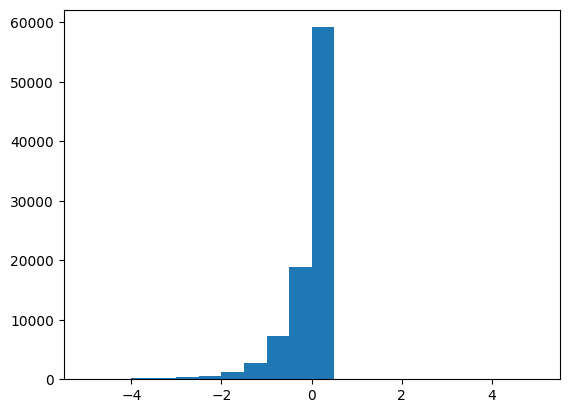

In [11]:
plt.hist(basic_price_diff, bins=20, range=[-5, 5])
plt.show()

Active listing basic price < listing web price

In [12]:
promo_price_diff = df.lw_price - df.lw_promo_price
promo_price_diff = promo_price_diff[~promo_price_diff.isna()]

In [13]:
promo_price_diff.shape

(42377,)

In [14]:
promo_price_diff.describe()

count    42377.000000
mean         9.048504
std         18.389597
min          0.020000
25%          2.000000
50%          4.610000
75%          9.860000
max       1120.000000
dtype: float64

In [15]:
np.sum(np.logical_or(promo_price_diff > 100, promo_price_diff < 0))

217

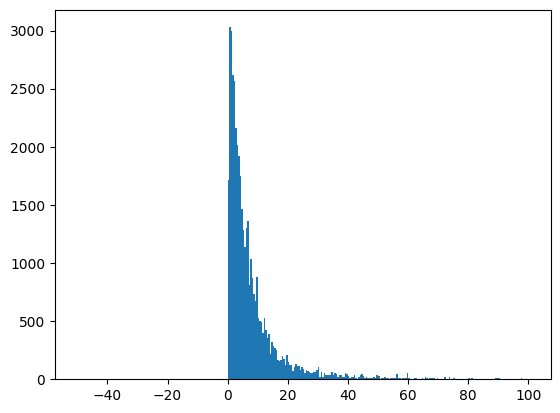

In [16]:
plt.hist(promo_price_diff, bins=300, range=[-50, 100])
plt.show()

In [17]:
real_price_seq = []
alb_real_diff = []
for i in range(df.shape[0]):
    alb_price = df.alb_price[i]
    lw_price = df.lw_price[i]
    promo_price = df.lw_promo_price[i]
    
    base_price = lw_price if lw_price > 0.0 else alb_price
    real_price = base_price if math.isnan(promo_price) else promo_price
    real_price_seq.append(real_price)

    price_diff = real_price - alb_price
    alb_real_diff.append(price_diff)

In [18]:
len(alb_real_diff)

91531

In [20]:
np.sum(np.logical_or(np.array(alb_real_diff) > 50, np.array(alb_real_diff) < -50))

844

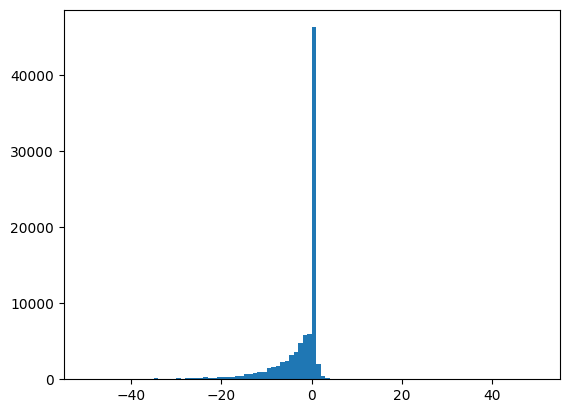

In [21]:
plt.hist(alb_real_diff, bins=100, range=[-50, 50])
plt.show()

In [22]:
print(len(alb_real_diff))
print(np.median(alb_real_diff))
print(np.mean(alb_real_diff))
print(np.quantile(alb_real_diff, 0.25))
print(np.sum(np.array(alb_real_diff) < -5))

91531
0.0
-3.8925541073516077
-3.960000000000001
19214


In [23]:
discount = df.lw_promo_price / df.lw_price
discount = discount[~discount.isna()]

In [24]:
discount.describe()

count    42377.000000
mean         0.652127
std          0.184539
min          0.246667
25%          0.500000
50%          0.700000
75%          0.800000
max          0.958333
dtype: float64

(array([ 3163.,   664.,  2831.,  6972.,  4064.,  1420.,  3906., 11858.,
         2790.,  4709.]),
 array([0.24666667, 0.31783333, 0.389     , 0.46016667, 0.53133333,
        0.6025    , 0.67366667, 0.74483333, 0.816     , 0.88716667,
        0.95833333]),
 <BarContainer object of 10 artists>)

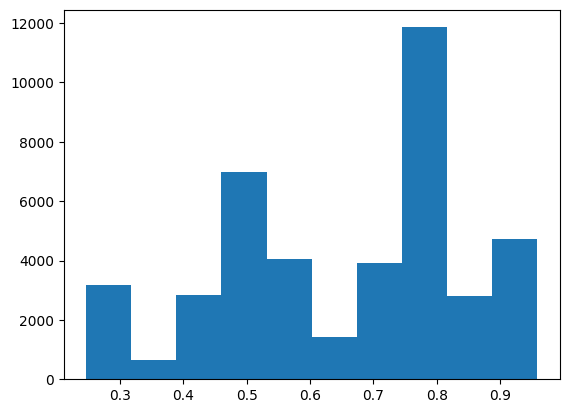

In [25]:
plt.hist(discount)

In [26]:
print(df.lw_price[~df.lw_promo_price.isna()].median())
print(df.lw_price[df.lw_promo_price.isna()].median())

15.99
10.68


In [30]:
print(df.alb_price.mean())
print(df.alb_price.median())

21.26549977603216
12.84


In [31]:
print(np.mean(real_price_seq))
print(np.median(real_price_seq))

17.372945668680558
10.01
